<a href="https://colab.research.google.com/github/jeetsingh87fl-cyber/Business-Project-/blob/main/M516_(GH1028970).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

M516 BUSINESS PROJECT IN BIG DATA AND AI

BY: JEET DEVRAJ SINGH

Dataset Link: https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation

Importing standard data science libraries

In [77]:
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

Scikit-learn for preprocessing, modeling and evaluation

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

For saving the trained pipeline

In [58]:
import joblib

Load dataset and quick EDA

In [59]:
DATA_PATH = '/content/Carbon Emission.csv'
print(' Loading dataset from:', DATA_PATH)
df = pd.read_csv(DATA_PATH)

 Loading dataset from: /content/Carbon Emission.csv


Showing top rows and basic information

In [60]:
print('\n Dataset head:')
display(df.head())
print('\n Shape:', df.shape)
print('\n Column types and non-null counts:')
print(df.info())


 Dataset head:


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743



 Shape: (10000, 20)

 Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Wast

Missing values overview

In [61]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if missing.empty:
    print('\n No missing values found.')
else:
    print('\n Missing values by column (showing only columns with missing):')
    display(missing.reset_index().rename(columns={'index':'column',0:'missing_count'}))


 Missing values by column (showing only columns with missing):


,column,missing_count
0,Vehicle Type,6721


Identify target column

In [62]:
candidate_keywords = ['carbon', 'emiss', 'co2', 'footprint', 'ghg']
candidates = [col for col in df.columns if any(re.search(k, col, flags=re.I) for k in candidate_keywords)]

if len(candidates) >= 1:
    target_col = candidates[0]
    print(f"\n Identified target column by keyword: '{target_col}'")
else:
    target_col = df.columns[-1]
    print(f"\n Could not find a clear target by keywords; using last column as target: '{target_col}'")



 Identified target column by keyword: 'CarbonEmission'


ensure target numeric

In [63]:
if not np.issubdtype(df[target_col].dtype, np.number):
    print(f"\n Attempting to convert '{target_col}' to numeric.")
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

print(f"\n Target ('{target_col}') summary:")
display(df[target_col].describe().to_frame().T)


 Target ('CarbonEmission') summary:


,count,mean,std,min,25%,50%,75%,max
CarbonEmission,10000.0,2269.1473,1017.675247,306.0,1538.0,2080.0,2768.0,8377.0


Prepare features, impute missing values, and build preprocessing pipeline

In [64]:
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

numeric_cols = X.select_dtypes(include=['int64','float64','int32','float32','float']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('\n Feature separation:')
print('Numeric features:', numeric_cols)
print('Categorical features:', categorical_cols)


 Feature separation:
Numeric features: ['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour']
Categorical features: ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 'Vehicle Type', 'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency', 'Recycling', 'Cooking_With']


Imputation and scaling.

In [65]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

Train-test split

In [66]:
print('\n Splitting data into train and test sets (80/20)...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


 Splitting data into train and test sets (80/20)...
Train shape: (8000, 19) Test shape: (2000, 19)


Build pipeline and train model

In [67]:
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

print('\n Training RandomForestRegressor pipeline...')
pipeline.fit(X_train, y_train)
print(' Training complete.')


 Training RandomForestRegressor pipeline...
 Training complete.


Evaluate model

In [68]:
print('\n Evaluating model on test set...')

y_pred = pipeline.predict(X_test)

# Calculate RMSE, MAE, and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Removed squared=False
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.nan

mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nResults on test set — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}, MAPE: {mape if not np.isnan(mape) else 'N/A'}")


 Evaluating model on test set...

Results on test set — RMSE: 284.1061, MAE: 216.0666, R^2: 0.9224, MAPE: 10.303824299251659


Predicted vs actual scatter

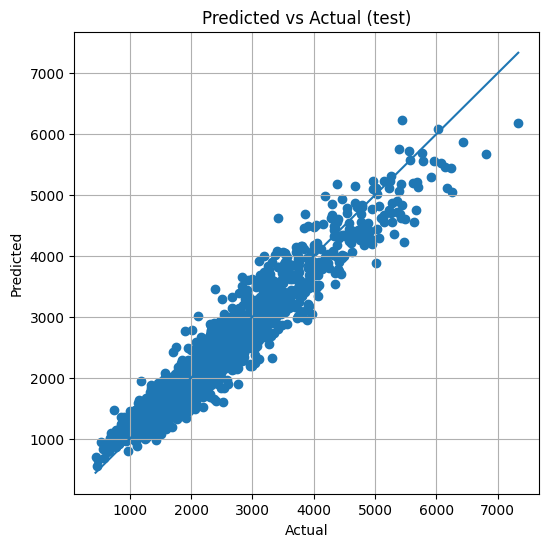

In [69]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual (test)')
plt.grid(True)
plt.show()

Feature importances

In [70]:
print('\n Extracting feature importances from the trained tree model...')

try:
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns)
except Exception:
    feature_names = []
    if numeric_cols:
        feature_names.extend(numeric_cols)
    if categorical_cols:
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        if hasattr(ohe, 'get_feature_names_out'):
            feature_names.extend(list(ohe.get_feature_names_out(categorical_cols)))
        else:
            for col in categorical_cols:
                uniques = X[col].astype(str).unique().tolist()
                feature_names.extend([f"{col}_{u}" for u in uniques])

raw_importances = pipeline.named_steps['model'].feature_importances_

feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': raw_importances}).sort_values('importance', ascending=False).reset_index(drop=True)
print('\n Top feature importances (post-preprocessing):')
display(feat_imp_df.head(40))


 Extracting feature importances from the trained tree model...

 Top feature importances (post-preprocessing):


,feature,importance
0,Vehicle Monthly Distance Km,0.375944
1,Frequency of Traveling by Air_very frequently,0.184505
2,Vehicle Type_electric,0.120792
3,How Many New Clothes Monthly,0.046286
4,Frequency of Traveling by Air_frequently,0.045814
5,Waste Bag Weekly Count,0.024846
6,Body Type_obese,0.022718
7,Vehicle Type_hybrid,0.021870
8,Vehicle Type_petrol,0.020837
9,Heating Energy Source_electricity,0.011925


aggregate OHE importances to the original columns


 Aggregated importances by original column:


,original_feature,aggregated_importance
0,Vehicle Monthly Distance Km,0.375944
1,Frequency of Traveling by Air,0.233326
2,Vehicle Type,0.165147
3,How Many New Clothes Monthly,0.046286
4,Body Type,0.035200
5,Waste Bag Weekly Count,0.024846
6,Sex,0.022731
7,Heating Energy Source,0.019915
8,Waste Bag Size,0.017892
9,Monthly Grocery Bill,0.010351


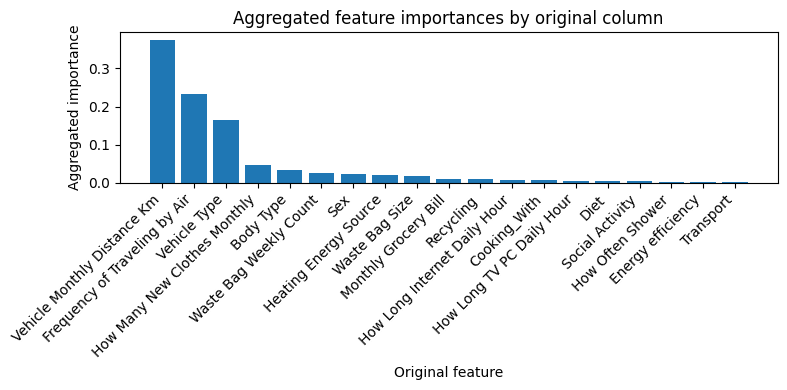

In [71]:
orig_columns = numeric_cols + categorical_cols
agg = {col: 0.0 for col in orig_columns}
for fname, imp in zip(feature_names, raw_importances):
    matched = False
    for col in orig_columns:
        if fname.startswith(col):
            agg[col] += imp
            matched = True
            break
    if not matched:
        agg.setdefault('other', 0.0)
        agg['other'] += imp

agg_df = pd.DataFrame([{'original_feature': k, 'aggregated_importance': v} for k, v in agg.items()]).sort_values('aggregated_importance', ascending=False).reset_index(drop=True)
print('\n Aggregated importances by original column:')
display(agg_df)

plt.figure(figsize=(8,4))
plt.bar(agg_df['original_feature'], agg_df['aggregated_importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Original feature')
plt.ylabel('Aggregated importance')
plt.title('Aggregated feature importances by original column')
plt.tight_layout()
plt.show()

Recommendation layer — simulate "what-if" scenarios

In [72]:
print('\n Building recommendation layer that simulates "what-if" behaviour changes...')

def predict_for_modified_sample(sample_raw: pd.Series, modifications: dict, pipeline_model: Pipeline):
    sample_copy = sample_raw.copy()
    for k, v in modifications.items():
        sample_copy[k] = v
    sample_df = pd.DataFrame([sample_copy])
    return float(pipeline_model.predict(sample_df)[0])



 Building recommendation layer that simulates "what-if" behaviour changes...


main recommendation function

In [73]:
def recommend_behavioral_changes(sample_idx=None, sample_raw=None, X_raw=X_test, top_k=5, reductions=[0.10, 0.25, 0.50]):
    if sample_raw is None:
        if sample_idx is None:
            sample_idx = X_test.index[0]
        sample_raw = X_raw.loc[sample_idx]
    else:
        sample_raw = sample_raw.reindex(X.columns)

    baseline_pred = float(pipeline.predict(pd.DataFrame([sample_raw]))[0])
    if baseline_pred == 0:
        baseline_pred = 1e-9

    top_features = agg_df['original_feature'].tolist()[:top_k]

    sim_results = []
    for feat in top_features:
        if feat == 'other':
            continue
        if feat in numeric_cols:
            orig_val = sample_raw[feat]
            try:
                orig_val_num = float(orig_val)
            except:
                continue
            for red in reductions:
                new_val = orig_val_num * (1 - red)
                new_pred = predict_for_modified_sample(sample_raw, {feat: new_val}, pipeline)
                reduction_abs = baseline_pred - new_pred
                reduction_pct = (reduction_abs / baseline_pred) * 100
                sim_results.append({'feature': feat, 'action': f"Reduce {feat} by {int(red*100)}%", 'baseline_pred': baseline_pred, 'new_pred': new_pred, 'reduction_abs': reduction_abs, 'reduction_pct': reduction_pct})
        elif feat in categorical_cols:
            col = feat
            cat_means = df.groupby(col)[target_col].mean().sort_values()
            cat_means = cat_means.dropna()
            if cat_means.empty:
                continue
            best_cat = cat_means.index[0]
            current_cat = sample_raw[col]
            if current_cat == best_cat:
                continue
            new_pred = predict_for_modified_sample(sample_raw, {col: best_cat}, pipeline)
            reduction_abs = baseline_pred - new_pred
            reduction_pct = (reduction_abs / baseline_pred) * 100
            sim_results.append({'feature': col, 'action': f"Switch {col} from '{current_cat}' to '{best_cat}'", 'baseline_pred': baseline_pred, 'new_pred': new_pred, 'reduction_abs': reduction_abs, 'reduction_pct': reduction_pct})
        else:
            continue

    sim_df = pd.DataFrame(sim_results).sort_values('reduction_pct', ascending=False).reset_index(drop=True)

    combined_actions = {}
    numeric_actions = sim_df[sim_df['action'].str.contains('Reduce')].head(3)
    for _, row in numeric_actions.iterrows():
        feat = row['feature']
        m = re.search(r"Reduce .* by (\d+)%", row['action'])
        if m:
            red_percent = int(m.group(1))/100.0
            new_val = float(sample_raw[feat]) * (1 - red_percent)
            combined_actions[feat] = new_val
    if combined_actions:
        new_pred = predict_for_modified_sample(sample_raw, combined_actions, pipeline)
        reduction_abs = baseline_pred - new_pred
        reduction_pct = (reduction_abs / baseline_pred) * 100
        comb_row = {'feature': '+'.join(list(combined_actions.keys())), 'action': f"Combined reductions: {', '.join([f"{k} -> {v:.3f}" for k,v in combined_actions.items()])}", 'baseline_pred': baseline_pred, 'new_pred': new_pred, 'reduction_abs': reduction_abs, 'reduction_pct': reduction_pct}
        sim_df = pd.concat([sim_df, pd.DataFrame([comb_row])], ignore_index=True)

    return baseline_pred, sim_df

Example recommendations for a test sample


 Example: generating recommendations for a test sample...

Baseline predicted carbon footprint for sample index 6252: 1165.0050



,feature,action,baseline_pred,new_pred,reduction_abs,reduction_pct
0,How Many New Clothes Monthly,Reduce How Many New Clothes Monthly by 50%,1165.005,963.110,201.895,17.329969
1,Waste Bag Weekly Count,Reduce Waste Bag Weekly Count by 50%,1165.005,985.820,179.185,15.380621
2,How Many New Clothes Monthly,Reduce How Many New Clothes Monthly by 25%,1165.005,1011.250,153.755,13.197797
3,Frequency of Traveling by Air,Switch Frequency of Traveling by Air from 'rar...,1165.005,1103.030,61.975,5.319720
4,How Many New Clothes Monthly,Reduce How Many New Clothes Monthly by 10%,1165.005,1135.925,29.080,2.496127
5,Body Type,Switch Body Type from 'normal' to 'underweight',1165.005,1146.325,18.680,1.603427
6,Waste Bag Weekly Count,Reduce Waste Bag Weekly Count by 10%,1165.005,1158.695,6.310,0.541629
7,Vehicle Monthly Distance Km,Reduce Vehicle Monthly Distance Km by 25%,1165.005,1159.180,5.825,0.499998
8,Waste Bag Weekly Count,Reduce Waste Bag Weekly Count by 25%,1165.005,1159.330,5.675,0.487122
9,Vehicle Monthly Distance Km,Reduce Vehicle Monthly Distance Km by 50%,1165.005,1159.350,5.655,0.485406


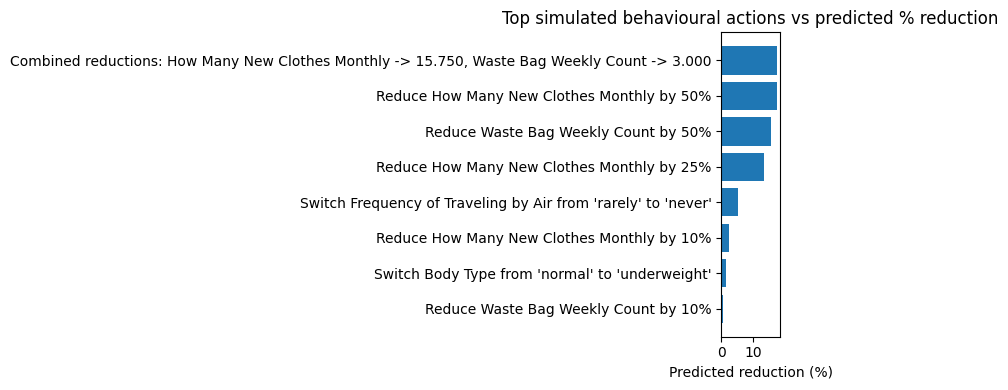

In [74]:
print('\n Example: generating recommendations for a test sample...')

example_idx = X_test.index[0]
baseline_val, recommendations_df = recommend_behavioral_changes(sample_idx=example_idx, top_k=6)

print(f"\nBaseline predicted carbon footprint for sample index {example_idx}: {baseline_val:.4f}\n")
if recommendations_df.empty:
    print('No actionable recommendations were generated for this sample (maybe all features are optimal or dataset is small).')
else:
    display(recommendations_df)
    to_plot = recommendations_df.sort_values('reduction_pct', ascending=False).head(8)
    plt.figure(figsize=(8,4))
    plt.barh(to_plot['action'].astype(str), to_plot['reduction_pct'])
    plt.xlabel('Predicted reduction (%)')
    plt.title('Top simulated behavioural actions vs predicted % reduction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

Step 10: Save the trained pipeline to disk

In [75]:
MODEL_OUT = '/content/carbon_recommender_pipeline.pkl'
joblib.dump(pipeline, MODEL_OUT)
print(f"\n Trained pipeline saved to: {MODEL_OUT}")


 Trained pipeline saved to: /content/carbon_recommender_pipeline.pkl


Final summary

In [76]:
print('\n Notebook script complete. Key points:')
print('- Median imputation for numeric, mode imputation + OneHotEncoder for categorical.')
print('- RandomForest pipeline used for prediction; metrics printed above.')
print('- Recommendation layer simulates per-feature and combined changes and shows predicted impact.')
print('\n Tip: To run this in Google Colab, upload the CSV to /content or mount Google Drive and update DATA_PATH accordingly.')


 Notebook script complete. Key points:
- Median imputation for numeric, mode imputation + OneHotEncoder for categorical.
- RandomForest pipeline used for prediction; metrics printed above.
- Recommendation layer simulates per-feature and combined changes and shows predicted impact.

 Tip: To run this in Google Colab, upload the CSV to /content or mount Google Drive and update DATA_PATH accordingly.


THANKYOU

JEET DEVRAJ SINGH(GH1028970)